In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# 生の文字列を使ってファイルパスを指定
file_path = r'C:\Users\nakan\Programing\.gpt\rawdata_tomato.csv'

# Excelファイルを読み込む
df = pd.read_csv(file_path)

# データの確認
print(df.tail())
print(df.info())

      ID  SEX  AGE  No2_Expensive  No2_Cheap  No2_TooExpensive  No2_TooCheap  \
174  215    1    7            150        100               200            90   
175  216    1   11            100         50               100            30   
176  217    1    9             70         65                75            60   
177  218    2    9             60         50               100            30   
178  219    1    9             50         20                60            20   

     No3_Expensive  No3_Cheap  No3_TooExpensive  ...  No8_Cheap  \
174            200        100               200  ...        120   
175            100         80               100  ...         50   
176             80         70                85  ...         70   
177            100         60               120  ...         60   
178             70         20                70  ...         60   

     No8_TooExpensive  No8_TooCheap  Shopping_frequency  Cooking_Frequency  \
174               300            90   

In [3]:
def PSM(df, Number):
    # 各質問に対する列名の定義
    too_cheap_col = f'No{Number}_TooCheap'
    too_expensive_col = f'No{Number}_TooExpensive'
    cheap_col = f'No{Number}_Cheap'
    expensive_col = f'No{Number}_Expensive'

    # データをソート
    df_sorted = df.sort_values(by=[too_cheap_col, too_expensive_col, cheap_col, expensive_col])

    # 価格の範囲を設定（0円から最大値まで1円刻み）
    price_range = np.arange(0, df_sorted[[too_cheap_col, too_expensive_col, cheap_col, expensive_col]].max().max() + 1, 1)

    # 各価格ポイントでの累積分布を計算
    too_cheap_cdf = np.array([(df_sorted[too_cheap_col] >= price).mean() for price in price_range])
    too_expensive_cdf = np.array([(df_sorted[too_expensive_col] <= price).mean() for price in price_range])
    cheap_cdf = np.array([(df_sorted[cheap_col] >= price).mean() for price in price_range])
    expensive_cdf = np.array([(df_sorted[expensive_col] <= price).mean() for price in price_range])

    # 線形補間関数を作成
    f_too_cheap = interp1d(price_range, too_cheap_cdf, bounds_error=False, fill_value="extrapolate")
    f_cheap = interp1d(price_range, cheap_cdf, bounds_error=False, fill_value="extrapolate")
    f_expensive = interp1d(price_range, expensive_cdf, bounds_error=False, fill_value="extrapolate")
    f_too_expensive = interp1d(price_range, too_expensive_cdf, bounds_error=False, fill_value="extrapolate")

    # 交点を見つけるための関数
    def find_intersection(func1, func2, x_range):
        differences = np.abs(func1(x_range) - func2(x_range))
        min_diff_index = np.argmin(differences)
        return x_range[min_diff_index], (func1(x_range[min_diff_index]) + func2(x_range[min_diff_index])) / 2

    # 交点を計算
    too_expensive_vs_cheap, too_expensive_vs_cheap_y = find_intersection(f_too_expensive, f_cheap, price_range)
    expensive_vs_cheap, expensive_vs_cheap_y = find_intersection(f_expensive, f_cheap, price_range)
    too_expensive_vs_too_cheap, too_expensive_vs_too_cheap_y = find_intersection(f_too_expensive, f_too_cheap, price_range)
    expensive_vs_too_cheap, expensive_vs_too_cheap_y = find_intersection(f_expensive, f_too_cheap, price_range)

    # 結果の表示
    print(f"IPP: {expensive_vs_cheap}")
    print(f"OPP: {too_expensive_vs_too_cheap}")
    print(f"HAP: {too_expensive_vs_cheap}")
    print(f"LAP: {expensive_vs_too_cheap}")

    # 累積分布の集計表を作成
    cumulative_df = pd.DataFrame({
        'Price': price_range,
        'Too_Cheap_CDF': too_cheap_cdf,
        'Too_Expensive_CDF': too_expensive_cdf,
        'Cheap_CDF': cheap_cdf,
        'Expensive_CDF': expensive_cdf
    })
    
    # 累積分布の集計表を表示
    print(cumulative_df)

    # プロットの作成
    plt.figure(figsize=(10, 6))
    plt.plot(price_range, too_cheap_cdf, label='Too Cheap')
    plt.plot(price_range, cheap_cdf, label='Cheap')
    plt.plot(price_range, expensive_cdf, label='Expensive')
    plt.plot(price_range, too_expensive_cdf, label='Too Expensive')

    # 交点をプロット
    plt.scatter([too_expensive_vs_cheap], [too_expensive_vs_cheap_y], color='red', label='HAP', zorder=5)
    plt.scatter([expensive_vs_cheap], [expensive_vs_cheap_y], color='green', label='IPP', zorder=5)
    plt.scatter([too_expensive_vs_too_cheap], [too_expensive_vs_too_cheap_y], color='blue', label='OPP', zorder=5)
    plt.scatter([expensive_vs_too_cheap], [expensive_vs_too_cheap_y], color='purple', label='LAP', zorder=5)

    # プロットの装飾
    plt.xlabel('Price')
    plt.ylabel('Cumulative Distribution')
    plt.title('Price Sensitivity Meter (PSM) Analysis')
    plt.legend()
    plt.grid(True)

    # プロットの表示
    plt.show()

IPP: 76
OPP: 70
HAP: 80
LAP: 60
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000        1.0            0.0
1        1       1.000000           0.000000        1.0            0.0
2        2       1.000000           0.000000        1.0            0.0
3        3       1.000000           0.000000        1.0            0.0
4        4       0.994413           0.000000        1.0            0.0
..     ...            ...                ...        ...            ...
296    296       0.000000           0.983240        0.0            1.0
297    297       0.000000           0.983240        0.0            1.0
298    298       0.000000           0.988827        0.0            1.0
299    299       0.000000           0.988827        0.0            1.0
300    300       0.000000           1.000000        0.0            1.0

[301 rows x 5 columns]


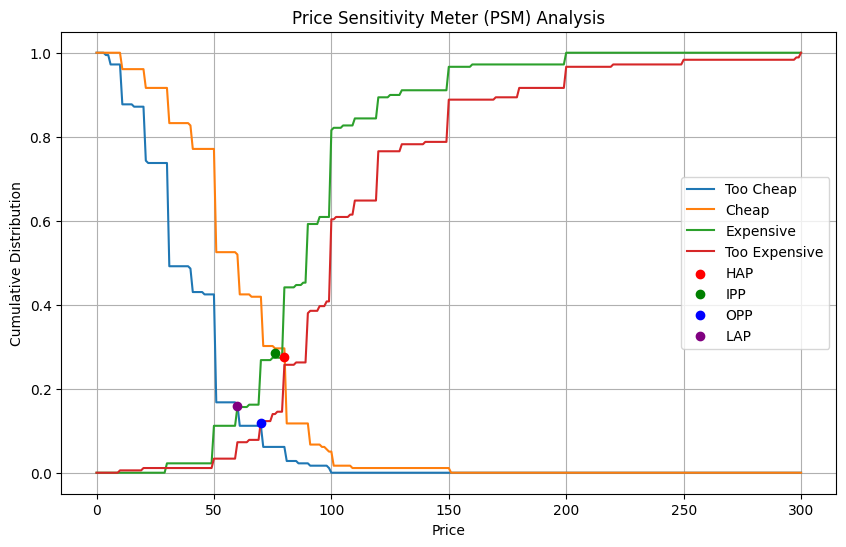

In [4]:
PSM(df,2)

IPP: 80
OPP: 75
HAP: 89
LAP: 70
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000        1.0       0.000000
1        1       1.000000           0.000000        1.0       0.000000
2        2       1.000000           0.000000        1.0       0.000000
3        3       0.994413           0.000000        1.0       0.000000
4        4       0.994413           0.000000        1.0       0.000000
..     ...            ...                ...        ...            ...
296    296       0.000000           0.977654        0.0       0.988827
297    297       0.000000           0.977654        0.0       0.988827
298    298       0.000000           0.983240        0.0       0.988827
299    299       0.000000           0.983240        0.0       0.988827
300    300       0.000000           1.000000        0.0       1.000000

[301 rows x 5 columns]


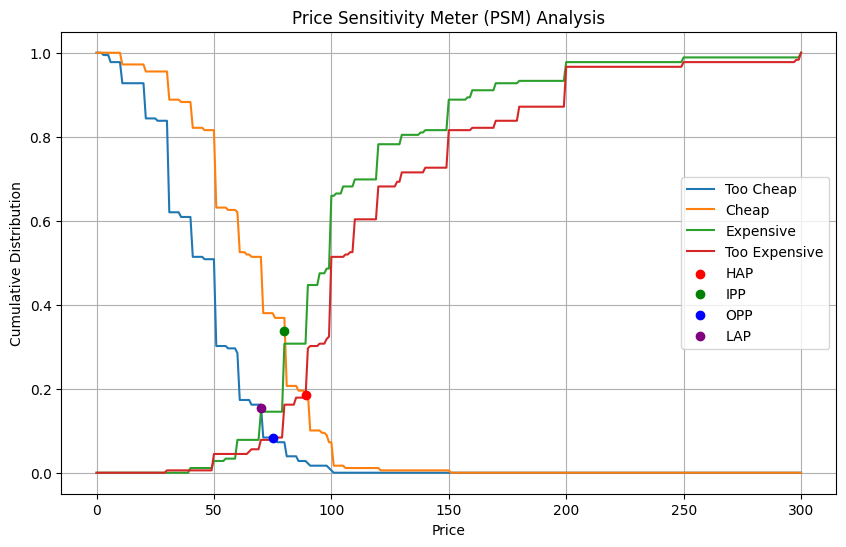

In [5]:
PSM(df,3)

IPP: 79
OPP: 70
HAP: 80
LAP: 66
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0            1.0           0.000000        1.0            0.0
1        1            1.0           0.000000        1.0            0.0
2        2            1.0           0.000000        1.0            0.0
3        3            1.0           0.000000        1.0            0.0
4        4            1.0           0.000000        1.0            0.0
..     ...            ...                ...        ...            ...
296    296            0.0           0.983240        0.0            1.0
297    297            0.0           0.983240        0.0            1.0
298    298            0.0           0.988827        0.0            1.0
299    299            0.0           0.988827        0.0            1.0
300    300            0.0           1.000000        0.0            1.0

[301 rows x 5 columns]


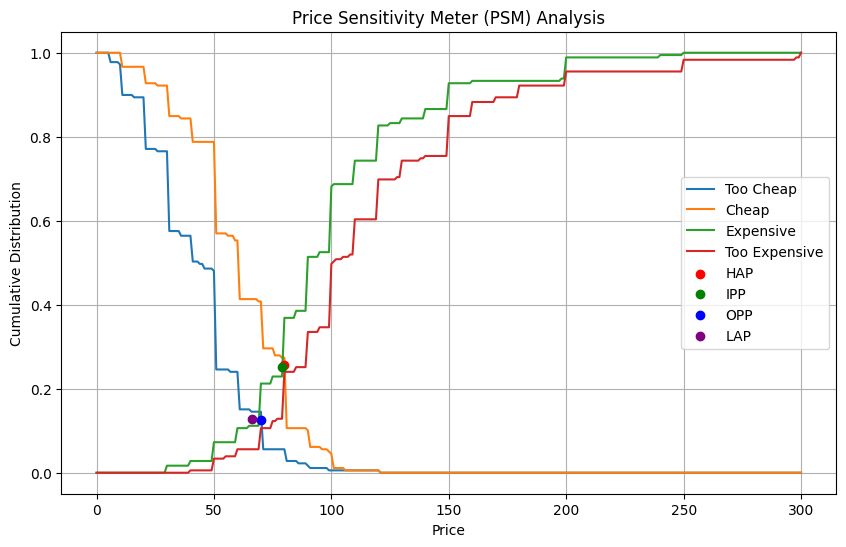

In [6]:
PSM(df,4)

IPP: 76
OPP: 70
HAP: 80
LAP: 61
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000   1.000000            0.0
1        1       0.994413           0.000000   0.994413            0.0
2        2       0.994413           0.000000   0.994413            0.0
3        3       0.994413           0.000000   0.994413            0.0
4        4       0.994413           0.000000   0.994413            0.0
..     ...            ...                ...        ...            ...
396    396       0.000000           0.994413   0.000000            1.0
397    397       0.000000           0.994413   0.000000            1.0
398    398       0.000000           0.994413   0.000000            1.0
399    399       0.000000           0.994413   0.000000            1.0
400    400       0.000000           1.000000   0.000000            1.0

[401 rows x 5 columns]


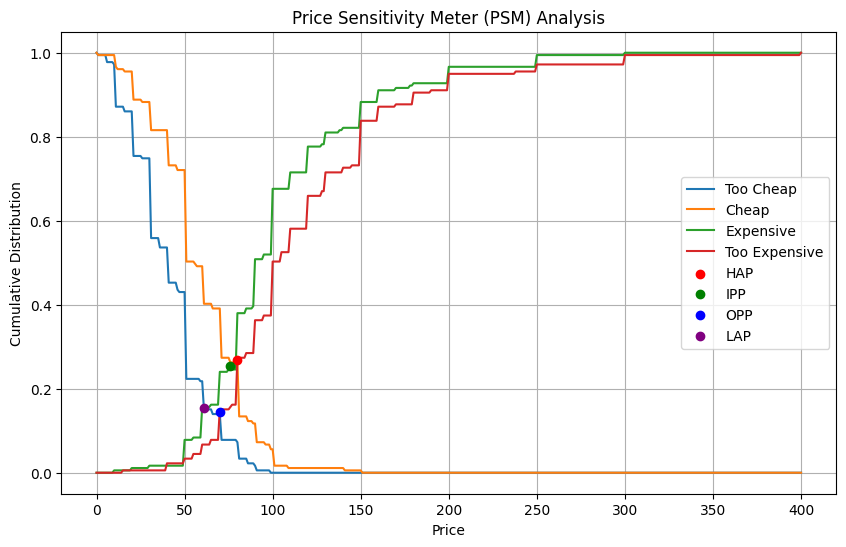

In [7]:
PSM(df,5)

IPP: 80
OPP: 71
HAP: 82
LAP: 70
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0            1.0           0.000000        1.0            0.0
1        1            1.0           0.000000        1.0            0.0
2        2            1.0           0.000000        1.0            0.0
3        3            1.0           0.000000        1.0            0.0
4        4            1.0           0.000000        1.0            0.0
..     ...            ...                ...        ...            ...
346    346            0.0           0.994413        0.0            1.0
347    347            0.0           0.994413        0.0            1.0
348    348            0.0           0.994413        0.0            1.0
349    349            0.0           0.994413        0.0            1.0
350    350            0.0           1.000000        0.0            1.0

[351 rows x 5 columns]


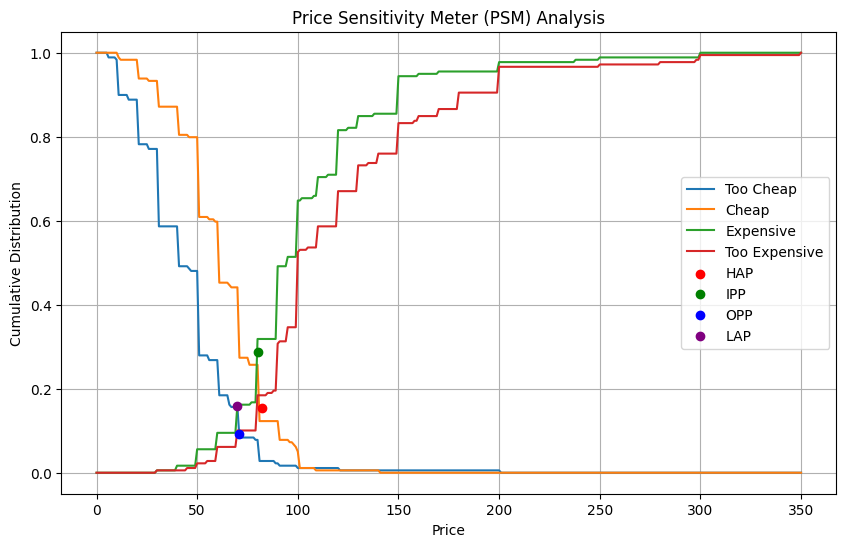

In [8]:
PSM(df,6)

IPP: 70
OPP: 66
HAP: 79
LAP: 60
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0            1.0           0.000000        1.0       0.000000
1        1            1.0           0.000000        1.0       0.000000
2        2            1.0           0.000000        1.0       0.000000
3        3            1.0           0.000000        1.0       0.000000
4        4            1.0           0.000000        1.0       0.000000
..     ...            ...                ...        ...            ...
496    496            0.0           0.994413        0.0       0.994413
497    497            0.0           0.994413        0.0       0.994413
498    498            0.0           0.994413        0.0       0.994413
499    499            0.0           0.994413        0.0       0.994413
500    500            0.0           1.000000        0.0       1.000000

[501 rows x 5 columns]


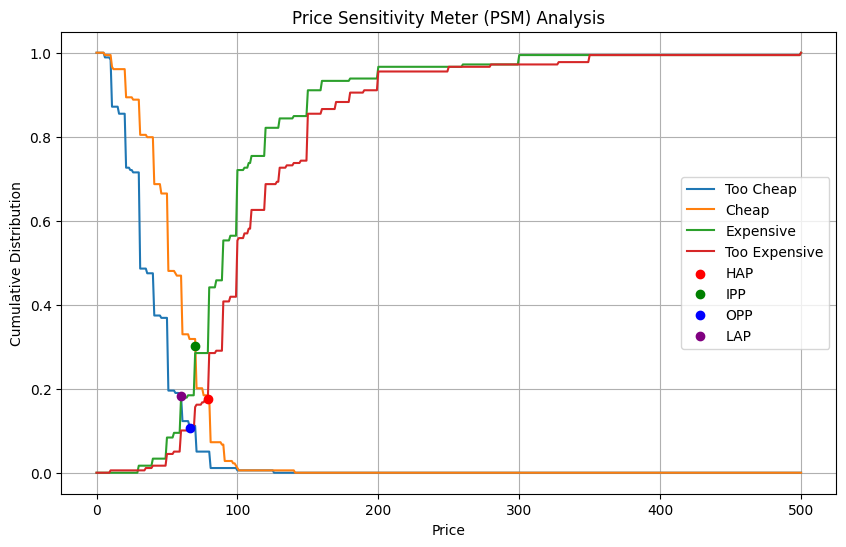

In [9]:
PSM(df,7)

IPP: 81
OPP: 76
HAP: 81
LAP: 71
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0            1.0           0.000000        1.0            0.0
1        1            1.0           0.000000        1.0            0.0
2        2            1.0           0.000000        1.0            0.0
3        3            1.0           0.000000        1.0            0.0
4        4            1.0           0.000000        1.0            0.0
..     ...            ...                ...        ...            ...
596    596            0.0           0.994413        0.0            1.0
597    597            0.0           0.994413        0.0            1.0
598    598            0.0           0.994413        0.0            1.0
599    599            0.0           0.994413        0.0            1.0
600    600            0.0           1.000000        0.0            1.0

[601 rows x 5 columns]


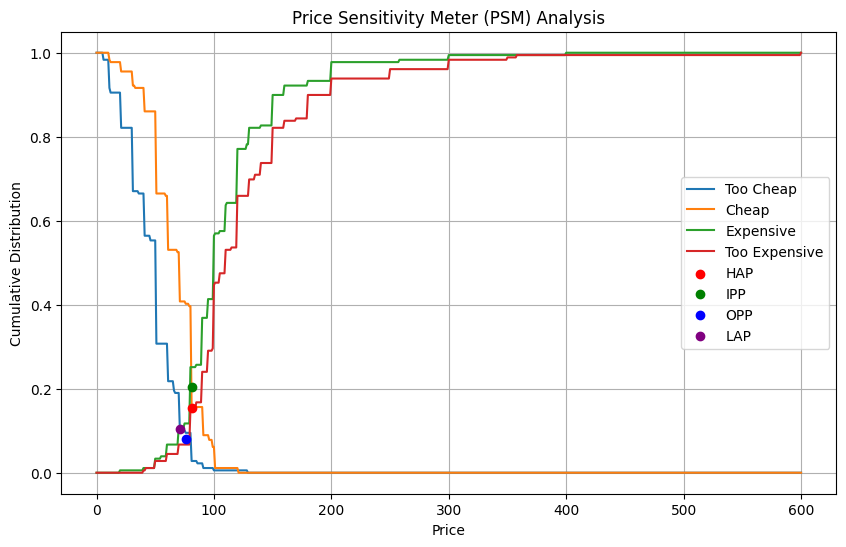

In [10]:
PSM(df,8)

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# データフレームの作成
data = pd.DataFrame({
    'A': [0, 1, 0, 1, 0, 1, 0, 1],
    'B': [0, 0, 1, 1, 0, 0, 1, 1],
    'C': [0, 0, 0, 0, 1, 1, 1, 1],
    'score': [100, 75.5, 77.5, 73, 78.5, 73, 74.5, 68]
})

# A, B, C をカテゴリカル変数として指定
data['A'] = data['A'].astype('category')
data['B'] = data['B'].astype('category')
data['C'] = data['C'].astype('category')

# ANOVAモデルの作成（交互作用を減らす）
model = ols('score ~ A + B + C', data=data).fit()

# ANOVA表の出力
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

           sum_sq   df         F    PR(>F)
A         210.125  1.0  4.991834  0.089190
B         144.500  1.0  3.432814  0.137545
C         128.000  1.0  3.040831  0.156143
Residual  168.375  4.0       NaN       NaN


In [12]:
# ANOVAモデルの作成（A×B×C以外の交互作用を含める）
model_interactions = ols('score ~ A * B + A * C + B * C', data=data).fit()

# ANOVA表の出力
anova_table_interactions = sm.stats.anova_lm(model_interactions, typ=2)
anova_table_interactions

,sum_sq,df,F,PR(>F)
A,210.125,1.0,3.811791,0.301348
B,144.500,1.0,2.621315,0.352238
C,128.000,1.0,2.321995,0.369721
A:B,45.125,1.0,0.818594,0.531805
A:C,36.125,1.0,0.655329,0.566767
B:C,32.000,1.0,0.580499,0.585512
Residual,55.125,1.0,NaN,NaN
